# Reading Data

We read data and load them to dataframes, as well as the recommended indices.

In [1]:
from scipy.io import arff
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
    
data_path = "../Data/train_arff/"
# read and sort the speech files
speech_files = sorted([data_path+file for file in os.listdir(data_path) if 'speech' in file], \
                      key=lambda file_name: int(re.findall(r"\d+", file_name)[0]))
print("File names succesfully loaded!")
print(speech_files)

File names succesfully loaded!
['../Data/train_arff/1.speech.arff', '../Data/train_arff/2.speech.arff', '../Data/train_arff/3.speech.arff', '../Data/train_arff/4.speech.arff', '../Data/train_arff/5.speech.arff', '../Data/train_arff/6.speech.arff', '../Data/train_arff/7.speech.arff', '../Data/train_arff/8.speech.arff', '../Data/train_arff/9.speech.arff', '../Data/train_arff/10.speech.arff', '../Data/train_arff/11.speech.arff', '../Data/train_arff/12.speech.arff', '../Data/train_arff/13.speech.arff', '../Data/train_arff/14.speech.arff']


First of all, let's fix the seed so that every action is reproducible.

In [2]:
np.random.seed(7)

### Examining Data Distributions

Now let's examine the distributions of each file

/Users/kareem/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


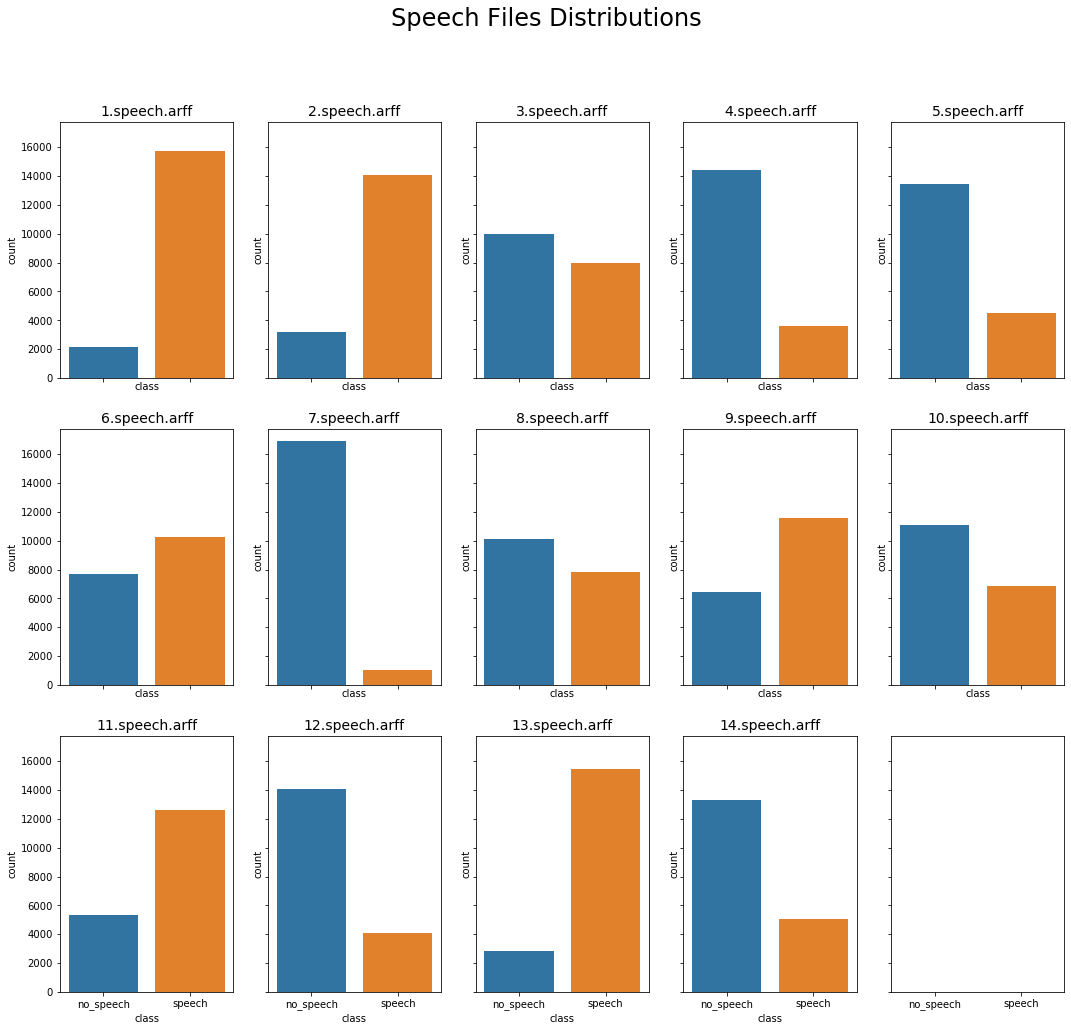

In [3]:
from seaborn import countplot
fig, ax = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(18, 16))
i, j = 0, 0
for file in speech_files:
    data, _ = arff.loadarff(file)
    ## Convert to a dataframe
    data = pd.DataFrame(data)
    # change labels in the dataset from 0 1 to string labels
    data['class'] = np.array(["speech" if i == b'speech' else 'no_speech' for i in data['class'].values])
    ax[i,j].set_title(file[19:], fontsize=14)
    countplot(x="class", data=data, ax=ax[i,j])
    j+=1;
    if j%5 == 0:
        j=0; i+=1
fig.suptitle("Speech Files Distributions", fontsize=24)
fig.savefig('../Visualization/Speech-Files-Distributions.png')
fig.show()

It looks like file 3, 6, 8, 9, 10 aren't that heavily imbalanced, so I'll select those files among other for all three purposes: training, validation and testing. 

In [4]:
selected_files = ['../Data/train_arff/3.speech.arff', '../Data/train_arff/6.speech.arff', '../Data/train_arff/8.speech.arff', '../Data/train_arff/9.speech.arff', '../Data/train_arff/10.speech.arff']
print(len(selected_files))

5


Stack the data from separate files on top of each other.

In [5]:
dataset = None
for file in selected_files:
    print("Loading file", file[19:])
    data, _ = arff.loadarff(file)
    ## Concatenate the files on top of each other
    dataset = pd.DataFrame(data) if dataset is None else pd.concat([dataset, pd.DataFrame(data)], ignore_index=True)
    # change labels in the dataset from 0 1 to string labels
    dataset['class'] = np.array(["speech" if i == b'speech' else 'no_speech' for i in dataset['class'].values])
print("Files are loaded!")
X, y = dataset.iloc[:,:-1].values, dataset.iloc[:,-1].values

Loading file 3.speech.arff
Loading file 6.speech.arff
Loading file 8.speech.arff
Loading file 9.speech.arff
Loading file 10.speech.arff
Files are loaded!


## Preprocessing

### Standardization

As suggested by @Markus, we standardize the data

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Feature Selection

Now that we've standardize the data, let's move features selection. For that purpose I used [Univariate Selection](https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e). In the following we see the features sorted according to the strongest relationship with the output variable $y$.

`f_classif`: Computes the ANOVA F-value for the provided sample

In [7]:
from sklearn.feature_selection import SelectKBest, f_classif
#apply SelectKBest class to extract top 100 best features
bestfeatures = SelectKBest(score_func=f_classif, k=103)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(dataset.columns[:-1])
#concat two dataframes for better visualization along the y-axis
featureScores = pd.concat([dfcolumns,dfscores], axis=1)
featureScores.columns = ['Feature','f_classif Score']  #naming the dataframe columns
featureScores.nlargest(75,'f_classif Score')

,Feature,f_classif Score
96,f000097,3798.353509
82,f000083,3795.978220
93,f000094,3627.150691
80,f000081,3375.827016
81,f000082,3119.100225
79,f000080,2550.277846
78,f000079,2405.994428
51,f000052,2392.760268
77,f000078,2360.503887
75,f000076,2290.512217


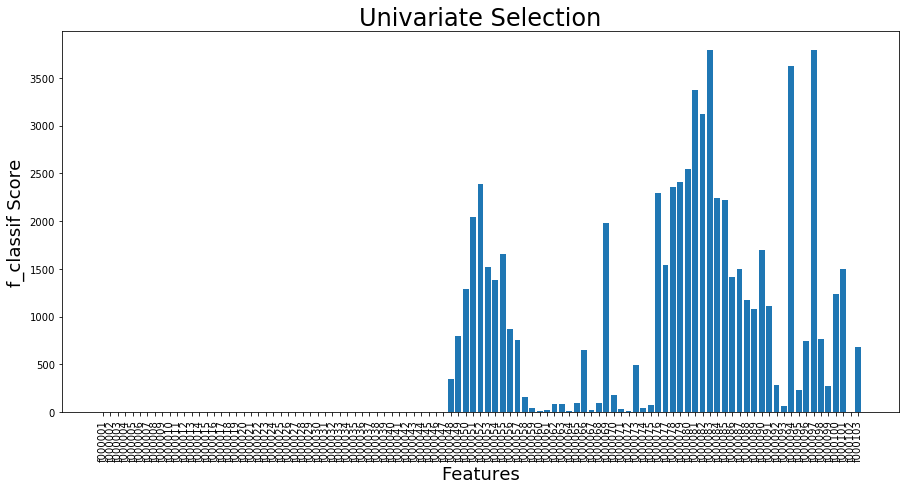

In [8]:
plt.figure(figsize=(15, 7))
plt.bar('Feature', 'f_classif Score', data=featureScores)
plt.title("Univariate Selection", fontsize=24)
plt.ylabel("f_classif Score", fontsize=18)
plt.xlabel("Features", fontsize=18)
plt.xticks(rotation='vertical')
fig.savefig('../Visualization/Univariate-Selection-(k=75).png')
plt.show()

According to the plot, the first features don't have any importance on the variable $y$. To comply with @Markus's technique, I'm going to select those features from Random Forest too. We'll keep `max_features=auto`, since we don't want to influence that.

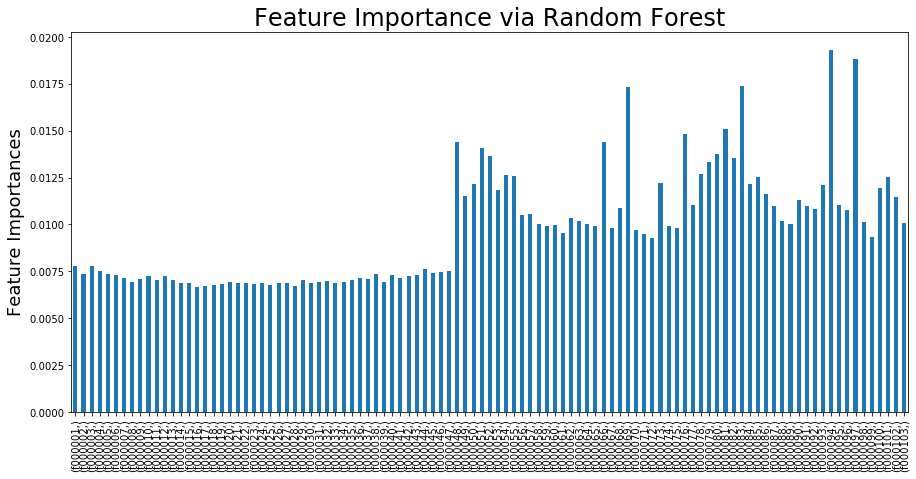

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
# keep max_features to auto
model = ExtraTreesClassifier(n_estimators=50)
model.fit(X,y)
#use inbuilt class feature_importances of tree based classifiers
feat_importances = pd.Series(model.feature_importances_, index=dfcolumns)
plt.figure(figsize=(15, 7))
feat_importances.plot(kind='bar')
plt.title("Feature Importance via Random Forest", fontsize=24)
plt.ylabel("Feature Importances", fontsize=18)
plt.savefig('../Visualization/Feature-Importance-via-Random-Forest-(k=75).png')
plt.show()

Random Forest confirms that the first features are less important than the rest and that they carry less information about $y$.

Now we're going to extract those features that are present in both RF and Univariate Selection.

In [10]:
extracted_features = np.array(
    sorted(
        # list comprehension to exract common features
        [feat[0] for feat in feat_importances.nlargest(75).index if feat[0] in featureScores.nlargest(75,'f_classif Score')['Feature'].values],
        # sort features according to the defualt order not importance score
        key= lambda feature_name: int(re.findall(r"\d+", feature_name)[0])
    )
)
print(extracted_features.shape)
print(extracted_features)

(61,)
['f000004' 'f000005' 'f000006' 'f000040' 'f000043' 'f000047' 'f000048'
 'f000049' 'f000050' 'f000051' 'f000052' 'f000053' 'f000054' 'f000055'
 'f000056' 'f000057' 'f000058' 'f000059' 'f000060' 'f000061' 'f000062'
 'f000063' 'f000064' 'f000065' 'f000066' 'f000067' 'f000068' 'f000069'
 'f000070' 'f000071' 'f000072' 'f000073' 'f000074' 'f000075' 'f000076'
 'f000077' 'f000078' 'f000079' 'f000080' 'f000081' 'f000082' 'f000083'
 'f000084' 'f000085' 'f000086' 'f000087' 'f000088' 'f000089' 'f000090'
 'f000091' 'f000092' 'f000093' 'f000094' 'f000095' 'f000096' 'f000097'
 'f000098' 'f000099' 'f000100' 'f000101' 'f000103']


Now we'll extract the features from the default dataset. `_fs` stands for feature selection. After that they're two issue to cover before starting training: a) There was some missing value in the data, and we would like to fill those by; b) we're going to use the principle component analysis to reduce the dimensionality even further, and make training a lot faster.

In [11]:
dataset_fs = dataset[extracted_features]

### Principle Component

The principle components doesn't imply losing information in the data, because variables aren't omitted from the dataset, they just get projected to new axes, unlike in feature selection. Nevertheless, we could do feature selection confidently because it was based on the combination of two different methods. Whereas, with the principle components we can't use ensemble method (at least none that I'm aware of), and therefore, I'd need to test the model's before and after applying the principle component analysis.

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
principalComponents = pca.fit_transform(X)
principalComponents.shape

(89842, 30)

>**Explained Variance**:
The explained variance tells you how much information (variance) can be attributed to each of the principal components. This is important as while you can convert 4 dimensional space to 2 dimensional space, you lose some of the variance (information) when you do this. By using the attribute explained_variance_ratio_, you can see that the first principal component contains 72.77% of the variance and the second principal component contains 23.03% of the variance. Together, the two components contain 95.80% of the information.

### Splitting Data (Using PCA)
Now we can finally split the data to $\text{Train}:\text{Validation}:\text{Test} \qquad 60:20:20$. So that we make sure that both that all training, validation and test sets have about the same portion of positive and negative classes, we're gonna use [stratified splitting](https://towardsdatascience.com/practical-tips-for-class-imbalance-in-binary-classification-6ee29bcdb8a7).

In [ ]:
# convert string labels to 1 and 0
y = np.where(y =='speech', 1, 0)

In [71]:
from sklearn.model_selection import train_test_split
# split 20% for validation, stratified
X_train, X_valid, y_train, y_valid = train_test_split(principalComponents, y, test_size=0.2, random_state=7, stratify=y)
# split 20% for testing, stratified
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=7, stratify=y_train)

## Utility Functions

Most utility functions are made available by Stefan. I just put them in `handsomeUtility.py`, so that they ready to import.

In [72]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
def plot_roc_curve(fpr, tpr, auc, title, figsize=(8,8)):
    """Plots the Receiver Operating Characteristic Curve
    @Params:
        fpr: (array-like) Flase positive rate
        tpr: (array-like) True positve rate
        auc: (float) Area Under the ROC curve
        figsize: (tuple) size of the produced image - default=(8,8)
    """
    plt.figure(figsize=figsize)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(title, fontsize=20)
    plt.legend(loc="lower right")
    plt.show()

### Smoothing

Was suggested by the blog post that @Stefan shared on Slack

In [15]:
def smooth_predictions(y_pred, window_size=1):
    """Implemetation of prediction smoothing. When incoherent predictions are encountered, they
    get strangled and replaced with neighboring ones. Window size can be controlled.
    @Params:
        y_pred: (array-like) vector of labels.
        window_size: (int, default=1) Increase the window size, if your model is likely to make too many
        false predictions in a row.
    @Returns: Smoothed array of same shape
    """
    for i in range(window_size, len(y_pred)-window_size):
        for w in range(window_size):
            w+=1
            if y_pred[i+w] == y_pred[i-w] and y_pred[i+w] != y_pred[i]:
                y_pred[i] = y_pred[i+w]
    return y_pred

Feel free to experiment with the following example for smoothing

In [16]:
myList = [1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
smooth_predictions(myList, window_size=2)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]

### Gain Matrix

In the following, we provide an implementation of the gain matrix, in a generic way.

![Gain-Matrix](../Info/Gain-Matrix.png)

In [20]:
import sys
def gain_matrix(y_true, y_pred, **kwargs):
    """Calculates the expected reward of a classifier's predictions"""
    rewardDict = dict()
    # 2 music-only
    # 1 music&speech
    # 0 nomusic
    #(True Value, Predicted Value)
    rewardDict[(0,0)] = 0
    rewardDict[(0,1)] = -1
    rewardDict[(0,2)] = -3.0
    rewardDict[(1,0)] = 0
    rewardDict[(1,1)] = 0.2
    rewardDict[(1,2)] = -2.0
    rewardDict[(2,0)] = 0
    rewardDict[(2,1)] = 0.2
    rewardDict[(2,2)] = 1.0
    
    reward = 0
    if len(y_true) != len(y_pred):
        print("Arrays are of two different lengths!!!", file=sys.stderr)
        return -1000000
    for index in range(len(y_true)):
        reward += rewardDict[(y_true[index], y_pred[index])]
    return reward

We can put that to the test the `gain_matrix` function to the test

In [28]:
my_true = [0, 0, 0, 1, 0, 1, 1, 2, 2]
my_pred = [2, 0, 1, 1, 1, 1, 1, 1, 2]
expected_reward = -3 + 0 -1 + 0.2  -1 + 0.2 + 0.2 + 0.2 + 1
returned_reward = gain_matrix(my_true, my_pred)
print(expected_reward == returned_reward)

my_true = [1, 1, 0, 1, 0, 1, 1, 2, 2]
my_pred = [0, 0, 1, 1, 1, 2, 1, 1, 0]
expected_reward = 0 + 0 -1 + 0.2 -1 -2 + 0.2 + 0.2 + 0
returned_reward = gain_matrix(my_true, my_pred)
print(expected_reward == returned_reward)

True
True


## Training 

### Logistic Regression (using PCA)

Here we're going to evaluate learning using the following 3 methods: Logistic Regression, SVM, and Random Forest. Evaluation is done using the validation set. 

Applying logistic regression on the data and see if we can take advantage of linearity.

* fit logistic regression
* get $y_{\text{pred}}$
* get accuracy, and AUC score
* Plot the ROC curve

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
def doTheLR():
    lr = LogisticRegression(solver='lbfgs', C=1.0)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_valid)
    # accuracy
    accuracy_lr = lr.score(X_valid, y_valid)
    print("Logistic Regression Accuracy =", accuracy_lr)
    auc_lr = roc_auc_score(y_pred_lr, y_valid)
    print("Logistic Regression AUC =", auc_lr)
    fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_valid, y_pred_lr)
    plot_roc_curve(fpr_lr, tpr_lr, auc_lr, "Logistic Regression")
    
    return y_pred_lr, accuracy_lr, auc_lr

Logistic Regression Accuracy = 0.8767321498135678
Logistic Regression AUC = 0.6969402306631163


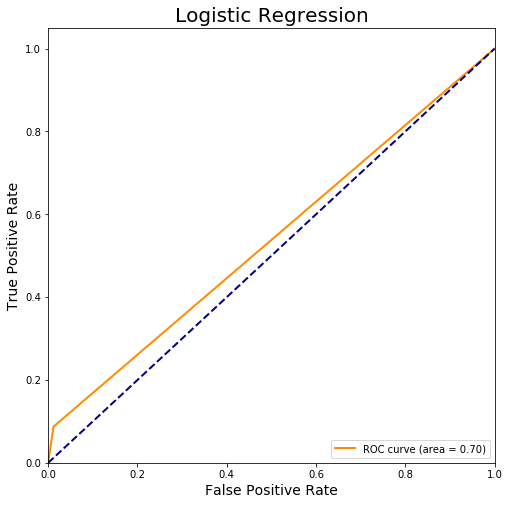

In [74]:
y_pred_lr, accuracy_lr, auc_lr = doTheLR()

### Support Vector Classifier (using PCA)

In [75]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
def doTheSVC():
    svc = SVC(C=1.0, kernel='rbf', degree=3)
    svc.fit(X_train, y_train)
    y_pred_svc = svc.predict(X_valid)
    # accuracy
    accuracy_svc = svc.score(X_valid, y_valid)
    print("SVC accuracy =", accuracy_svc)
    auc_svc = roc_auc_score(y_pred_svc, y_valid)
    print("SVC AUC =", auc_svc)
    fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_valid, y_pred_svc)
    plot_roc_curve(fpr_svc, tpr_svc, auc_svc, "SVM")
    
    return y_pred_svc, accuracy_svc, auc_svc

In [ ]:
y_pred_svc, accuracy_svc, auc_svc = doTheSVC()

### Random Forest (using PCA)

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
# default configuration of Random Forest
def doTheRF():
    rf = RandomForestClassifier(n_estimators=30)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_valid)
    # accuracy
    accuracy_rf = rf.score(X_valid, y_valid)
    print("Random Forest accuracy =", accuracy_rf)
    auc_rf = roc_auc_score(y_pred_rf, y_valid)
    print("Random Forest AUC =", auc_rf)
    fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_valid, y_pred_rf)
    plot_roc_curve(fpr_rf, tpr_rf, auc_rf, "Random Forest")
    
    return y_pred_rf, accuracy_rf, auc_rf

In [68]:
def doTheRF():
    # Stefan's configuration of Random Forest
    rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                                       max_depth=1000, max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0, min_impurity_split=None,
                                       min_samples_leaf=2, min_samples_split=6,
                                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
                                       oob_score=False, random_state=0, verbose=0, warm_start=False)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_valid)
    # accuracy
    accuracy_rf = rf.score(X_valid, y_valid)
    print("Random Forest accuracy =", accuracy_rf)
    auc_rf = roc_auc_score(y_pred_rf, y_valid)
    print("Random Forest AUC =", auc_rf)
    fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_valid, y_pred_rf)
    plot_roc_curve(fpr_rf, tpr_rf, auc_rf, "Random Forest")
    
    return y_pred_rf, accuracy_rf, auc_rf

Random Forest accuracy = 0.8786242974010796
Random Forest AUC = 0.7556919689152521


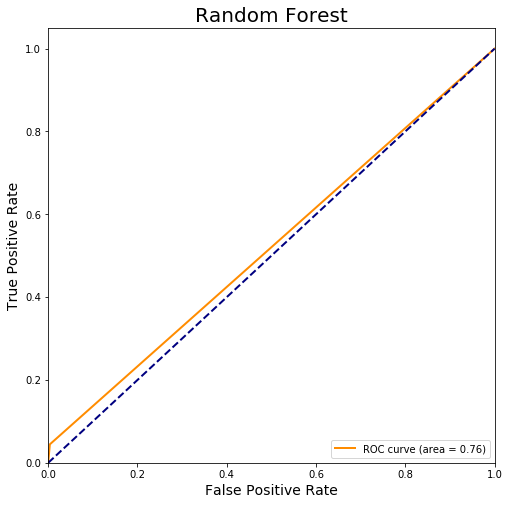

In [76]:
y_pred_rf, accuracy_rf, auc_rf = doTheRF()

### Neural Networks

In [77]:
from sklearn.neural_network import MLPClassifier
def doTheNN():
    nn = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
                   beta_2=0.999, early_stopping=False, epsilon=1e-08,
                   hidden_layer_sizes=100, learning_rate='constant',
                   learning_rate_init=0.001, max_iter=50, momentum=0.9,
                   n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
                   random_state=0, shuffle=True, solver='adam', tol=0.0001,
                   validation_fraction=0.1, verbose=False, warm_start=False)
    nn.fit(X_train, y_train)
    y_pred_nn = nn.predict(X_valid)
    # accuracy
    accuracy_nn = nn.score(X_valid, y_valid)
    print("Neural Network accuracy =", accuracy_nn)
    auc_nn = roc_auc_score(y_pred_nn, y_valid)
    print("Neural Network AUC =", auc_nn)
    fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_valid, y_pred_nn)
    plot_roc_curve(fpr_nn, tpr_nn, auc_nn, "MLP (Original Features)")
    
    return y_pred_nn, accuracy_nn, auc_nn

Neural Network accuracy = 0.8760643330179754
Neural Network AUC = 0.6965125287040421


/Users/kareem/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


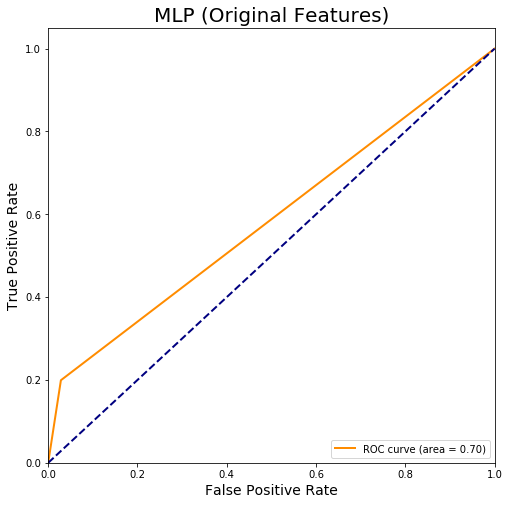

In [78]:
y_pred_nn, accuracy_nn, auc_nn = doTheNN()

Using the utility function `profit_score` that Stefan provided, I'm also going to estimate the reward that these models would get.

In [79]:
from handsomUtility import profit_score
reward_lr = profit_score(y_pred_lr, y_valid)
reward_svc = profit_score(y_pred_svc, y_valid)
reward_rf = profit_score(y_pred_rf, y_valid)
reward_nn = profit_score(y_pred_nn, y_valid)

In [81]:
pd.DataFrame.from_dict(
    {
        'Logistic Regression': {'Accuracy': accuracy_lr, 'AUC': auc_lr, 'Reward': reward_lr},
        'SVM': {'Accuracy': accuracy_svc, 'AUC': auc_svc, 'Reward': reward_svc},
        'Random Forest': {'Accuracy': accuracy_rf, 'AUC': auc_rf, 'Reward': reward_rf},
        'Neural Network': {'Accuracy': accuracy_nn, 'AUC': auc_nn, 'Reward': reward_nn}
    }, orient='index'
)

,Accuracy,AUC,Reward
Logistic Regression,0.876732,0.696940,-5890
Neural Network,0.876064,0.696513,-4894
Random Forest,0.878624,0.755692,-6270
SVM,0.881629,0.795651,-6018


Observing both the reward and the AUC, we can tell that PCA performs poorly for all these methods. Let's see if we can increase the score using the original features.
<br><br><br>

-----
<br><br><br>
Now we'll repeat each of the previous steps: splitting, training the same types of models, but only difference is that we're using original features this time instead of principle components.

In [85]:
from sklearn.model_selection import train_test_split
# split 20% for validation, stratified
X_train, X_valid, y_train, y_valid = train_test_split(dataset_fs.values, y, test_size=0.2, random_state=7, stratify=y)
# split 20% for testing, stratified
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=7, stratify=y_train)

### Logistic Regression (Original Features)

Logistic Regression Accuracy = 0.8779008292058545
Logistic Regression AUC = 0.7190206518535243


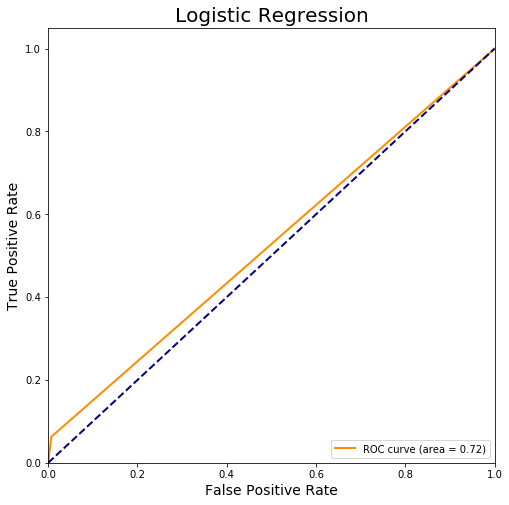

In [86]:
y_pred_lr, accuracy_lr, auc_lr = doTheLR()

### Support Vector Classifier (Original Features)

In [87]:
y_pred_svc, accuracy_svc, auc_svc = doTheSVC()

/Users/kareem/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC accuracy = 0.8763425900161389


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

### Random Forest (Original Features)

Random Forest accuracy = 0.8979353330736268
Random Forest AUC = 0.9208601133275809


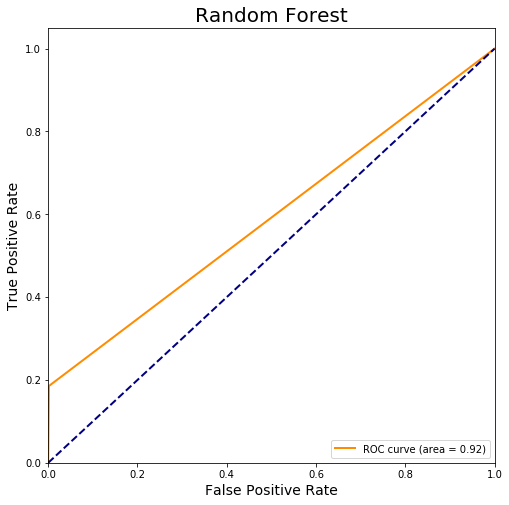

In [88]:
y_pred_rf, accuracy_rf, auc_rf = doTheRF()

### Neural Network (Original Features)

/Users/kareem/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Network accuracy = 0.8883076409371695
Neural Network AUC = 0.782087426156326


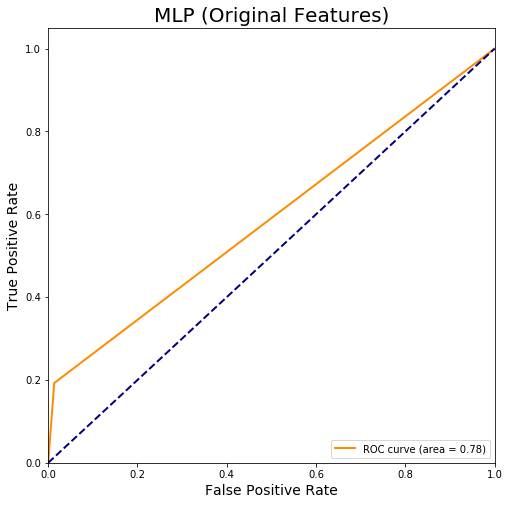

In [89]:
y_pred_nn, accuracy_nn, auc_nn = doTheNN()

In [90]:
from handsomUtility import profit_score
reward_lr = profit_score(y_pred_lr, y_valid)
reward_svc = profit_score(y_pred_svc, y_valid)
reward_rf = profit_score(y_pred_rf, y_valid)
reward_nn = profit_score(y_pred_nn, y_valid)

In [91]:
pd.DataFrame.from_dict(
    {
        'Logistic Regression': {'Accuracy': accuracy_lr, 'AUC': auc_lr, 'Reward': reward_lr},
        'SVM': {'Accuracy': accuracy_svc, 'AUC': auc_svc, 'Reward': reward_svc},
        'Random Forest': {'Accuracy': accuracy_rf, 'AUC': auc_rf, 'Reward': reward_rf},
        'Neural Network': {'Accuracy': accuracy_nn, 'AUC': auc_nn, 'Reward': reward_nn}
    }, orient='index'
)

,Accuracy,AUC,Reward
Logistic Regression,0.877901,0.719021,-6106
Neural Network,0.888308,0.782087,-4954
Random Forest,0.897935,0.920860,-5018
SVM,0.881629,0.795651,-6018


<br><br><br><br><br><br><br><br><br>

## Voting Classifier 

In [ ]:
VotingClassifier
voting = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('nn', nn)], voting='soft')